# Logistic Regression and PCA

Adjusted from [Kaggle notebook](https://www.kaggle.com/code/prashant111/eda-logistic-regression-pca) 

In [194]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

%matplotlib inline

## Import dataset

In [4]:
%%time

file = ('adult.csv')
df = pd.read_csv(file, encoding='latin-1')

Wall time: 78.9 ms


## Exploratory Data Analysis

### Check shape of dataset

In [5]:
df.shape

(32561, 15)

We can see that there are 32561 instances and 15 attributes in the data set.

### Preview dataset

In [6]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


### View summary of dataframe

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Summary of the dataset shows that there are no missing values. But the preview shows that the dataset contains values coded as `?`. So, I will encode `?` as NaN values.

### Encode `?` as `NaNs`

In [8]:
df[df == '?'] = np.nan

### Again check the summary of dataframe

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [10]:
df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

Now, the summary shows that the variables - `workclass`, `occupation` and `native.country` contain missing values. All of these variables are categorical data type. So, I will impute the missing values with the most frequent value- the mode.

### Impute missing values with mode

In [11]:
for col in ['workclass', 'occupation', 'native.country']:
    df[col].fillna(df[col].mode()[0], inplace=True)

### Check again for missing values

In [12]:
df.isnull().sum().sum()

0

Now we can see that there are no missing values in the dataset.

In [16]:
# Get counts of unique values for features based on dtypes
col_name = df.select_dtypes(include='object').columns

for index, col in enumerate(col_name):
    print(f'\033[1;3m{col_name[index]}:\033[0m\n{df[col].value_counts()}\n')

workclass:
Private             24532
Self-emp-not-inc     2541
Local-gov            2093
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

education:
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64

marital.status:
Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital.status, dtype: int64

occupation:
Prof-specialty       5983
Craft-repair         4099
Exec-managerial      40

### Setting feature vector and target variable

In [162]:
# Drop single value Holand-Netherlands of native.country for dummy encoding
df = df.loc[df['native.country'] != 'Holand-Netherlands']

In [163]:
X = df.drop(['income'], axis=1)
y = df['income']

In [164]:
X.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,90,Private,77053,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,4356,40,United-States
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States
2,66,Private,186061,Some-college,10,Widowed,Prof-specialty,Unmarried,Black,Female,0,4356,40,United-States
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States


## Split data into separate training and test set

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

## Feature Engineering

### Encode categorical variables

Note the difference of encoders!

**LabelEncoder** should be used to encode target values, i.e. y, and not the input X. Label encoding uses alphabetical ordering and expects a one-dimensional input for the single target variable. 

**OrdinalEncoder** is the same but intended for input variables that are organized into rows and columns. In ordinal encoding, each unique category value is assigned an integer value. Integer values have a natural ordered relationship between each other and machine learning algorithms may be able to understand and harness this relationship. It is a natural encoding for ordinal variables. For categorical variables, it imposes an ordinal relationship where no such relationship may exist. This can cause problems and a one-hot encoding may be used instead.

**OneHotEncoder:** For categorical variables where no ordinal relationship exists. Forcing an ordinal relationship via an ordinal encoding and allowing the model to assume a natural ordering between categories may result in poor performance or unexpected results (predictions halfway between categories). In this case, a one-hot encoding can be applied to the ordinal representation. This is where the integer encoded variable is removed and one new binary variable is added for each unique integer value in the variable.





In [215]:
## Example code
# ordinal encode input variables
# ordinal_encoder = OrdinalEncoder()
# ordinal_encoder.fit(X_train)
# X_train = ordinal_encoder.transform(X_train)
# X_test = ordinal_encoder.transform(X_test)

# ordinal encode target variable
# label_encoder = LabelEncoder()
# label_encoder.fit(y_train)
# y_train = label_encoder.transform(y_train)
# y_test = label_encoder.transform(y_test)

# one-hot encode input variables (equal to pd.get_dummies())
# onehot_encoder = OneHotEncoder()
# onehot_encoder.fit(X_train)
# X_train = onehot_encoder.transform(X_train)
# X_test = onehot_encoder.transform(X_test)

In [216]:
# Categories
label = ['income']
ordinal = ['education']
onehot = ['workclass', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']

In [217]:
# Encode label
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [218]:
# Ordinal encoding
ordinal_encoder = OrdinalEncoder()
X_train[ordinal] = ordinal_encoder.fit_transform(X_train[ordinal])
X_test[ordinal] = ordinal_encoder.transform(X_test[ordinal])

In [219]:
X_train.shape, X_test.shape

((22792, 14), (9768, 14))

In [220]:
# Dummy encoding
X_train = pd.get_dummies(X_train, drop_first=False)
X_test = pd.get_dummies(X_test, drop_first=False)

In [221]:
X_train.shape, X_test.shape

((22792, 89), (9768, 89))

In [222]:
X_train.head(3)

,age,fnlwgt,education,education.num,capital.gain,capital.loss,hours.per.week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
21386,66,112376,5.0,4,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
19750,25,114838,14.0,15,0,0,8,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1217,33,190772,11.0,9,0,1617,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [223]:
X_test.head()

,age,fnlwgt,education,education.num,capital.gain,capital.loss,hours.per.week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
14161,17,226717,2.0,8,0,0,20,0,0,0,...,0,0,0,0,0,0,0,1,0,0
27048,19,439779,15.0,10,0,0,15,0,0,0,...,0,0,0,0,0,0,0,1,0,0
28868,28,204734,15.0,10,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5668,52,94391,11.0,9,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7828,28,152951,11.0,9,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Feature Scaling

In [224]:
scaler = StandardScaler()

# Scale X_train and X_test separately
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [225]:
X_train.head()

,age,fnlwgt,education,education.num,capital.gain,capital.loss,hours.per.week,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
0,2.009289,-0.735326,-1.368398,-2.344253,-0.146514,-0.217132,-0.039104,-0.171607,-0.261327,-0.013249,...,-0.034439,-0.058222,-0.019875,-0.050945,-0.039774,-0.024792,-0.024792,0.306820,-0.04398,-0.022952
1,-0.997431,-0.711960,0.958024,1.901847,-0.146514,-0.217132,-2.647756,-0.171607,-0.261327,-0.013249,...,-0.034439,-0.058222,-0.019875,-0.050945,-0.039774,-0.024792,-0.024792,-3.259239,-0.04398,-0.022952
2,-0.410754,0.008704,0.182550,-0.414208,-0.146514,3.784281,-0.039104,-0.171607,-0.261327,-0.013249,...,-0.034439,-0.058222,-0.019875,-0.050945,-0.039774,-0.024792,-0.024792,0.306820,-0.04398,-0.022952
3,1.789285,0.645564,0.958024,1.901847,-0.146514,-0.217132,-0.039104,-0.171607,-0.261327,-0.013249,...,-0.034439,-0.058222,-0.019875,-0.050945,-0.039774,-0.024792,-0.024792,0.306820,-0.04398,-0.022952
4,-0.117415,1.055504,0.182550,-0.414208,-0.146514,-0.217132,0.368498,-0.171607,-0.261327,-0.013249,...,-0.034439,-0.058222,-0.019875,-0.050945,-0.039774,-0.024792,-0.024792,0.306820,-0.04398,-0.022952


## Logistic Regression model with all features

In [226]:
X_train.shape, X_test.shape

((22792, 89), (9768, 89))

In [227]:
y_train.shape, y_test.shape

((22792,), (9768,))

In [228]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Logistic Regression accuracy score with all features: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Logistic Regression accuracy score with all features: 0.8505


## Logistic Regression with PCA

Scikit-Learn's PCA class implements PCA algorithm using the code below. Before diving deep, I will explain another important concept called explained variance ratio.


### Explained Variance Ratio

A very useful piece of information is the **explained variance ratio** of each principal component. It is available via the `explained_variance_ratio_ ` variable. It indicates the proportion of the dataset’s variance that lies along the axis of each principal component.

Now, let's get to the PCA implementation.


In [229]:
pca = PCA()
X_train = pca.fit_transform(X_train)

pca.explained_variance_ratio_[:10]

array([0.05011274, 0.02964493, 0.02814169, 0.0232071 , 0.02037071,
       0.01945412, 0.01852754, 0.01622185, 0.01551659, 0.01484277])

In [230]:
np.cumsum(pca.explained_variance_ratio_)[:10]

array([0.05011274, 0.07975767, 0.10789935, 0.13110645, 0.15147716,
       0.17093128, 0.18945881, 0.20568066, 0.22119725, 0.23604002])

In [231]:
X_train.shape

(22792, 89)

In [232]:
pca.n_components_

89

In [233]:
pca.components_

array([[ 1.79382590e-01, -2.00862968e-02,  1.24274423e-02, ...,
         2.34243410e-02, -1.25898890e-02,  5.84673428e-03],
       [-2.18542615e-01,  9.07923027e-02, -1.67694595e-01, ...,
        -3.43018658e-01,  8.10334560e-02,  1.93187692e-02],
       [ 2.39493321e-01, -9.57357372e-03,  5.76854615e-03, ...,
        -3.40280648e-01,  1.03434442e-01,  7.35346895e-03],
       ...,
       [ 0.00000000e+00,  2.22044605e-16,  2.39624199e-16, ...,
        -4.91165639e-01, -7.68833092e-02, -4.01792294e-02],
       [ 0.00000000e+00, -1.52655666e-16, -3.49489687e-16, ...,
         4.99455404e-02,  7.81809256e-03,  4.08573639e-03],
       [ 0.00000000e+00,  4.16333634e-17,  1.80413234e-17, ...,
        -2.99292531e-01, -4.68489617e-02, -2.44832747e-02]])

## Select right number of components

- An approach to compute the number of components that can explain significantly large portion of the variance.

- The following code computes PCA without reducing dimensionality, then computes the minimum number of components required to preserve 90% of the training set variance.

In [234]:
pca = PCA()
pca.fit(X_train)

cumsum = np.cumsum(pca.explained_variance_ratio_)
pc = np.argmax(cumsum >= 0.90) + 1
print('The number of components required to preserve 90% of variance is', pc)

The number of components required to preserve 90% of variance is 68


**Explore code**

In [236]:
np.cumsum(pca.explained_variance_ratio_)[:10]

array([0.05011274, 0.07975767, 0.10789935, 0.13110645, 0.15147716,
       0.17093128, 0.18945881, 0.20568066, 0.22119725, 0.23604002])

In [237]:
pca.explained_variance_ratio_[:10]

array([0.05011274, 0.02964493, 0.02814169, 0.0232071 , 0.02037071,
       0.01945412, 0.01852754, 0.01622185, 0.01551659, 0.01484277])

In [238]:
# Return index of max value
pc = np.argmax(cumsum >= 0.90) + 1

In [239]:
cumsum >= 0.90

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [240]:
np.argmax(cumsum >= 0.90) 

67

### Comment

- With the required number of components found, we can then set number of components to `pc` and run PCA again.

- With the number of components set to `pc`, we can then calculate the required accuracy.

## Plot explained variance ratio with number of components

- An alternative option is to plot the explained variance as a function of the number of components.

- In the plot, we should look for an elbow where the explained variance stops growing fast.

- This can be thought of as the intrinsic dimensionality of the dataset.

- Now, I will plot cumulative explained variance ratio with number of components to show how variance ratio varies with number of components.

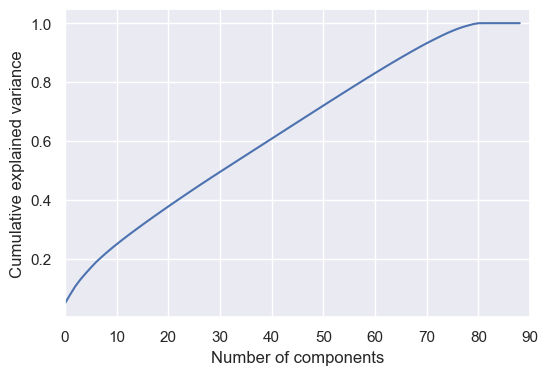

In [241]:
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,90,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');

## PCA in a model pipeline with Logistic Regression

In [242]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [243]:
# Encode label
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [244]:
# Ordinal encoding
ordinal = ['education']
ordinal_encoder = OrdinalEncoder()
X_train[ordinal] = ordinal_encoder.fit_transform(X_train[ordinal])
X_test[ordinal] = ordinal_encoder.transform(X_test[ordinal])

In [245]:
# Dummy encoding
X_train = pd.get_dummies(X_train, drop_first=False)
X_test = pd.get_dummies(X_test, drop_first=False)

In [263]:
# Play with the number of components and check the results
n_components=7

# Pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reducer', PCA(n_components=n_components)), 
    ('classifier', LogisticRegression())])

pipe.fit(X_train, y_train)

print(f"{n_components} components explain {pipe['reducer'].explained_variance_ratio_.sum()*100:.0f}% of the variance in the dataset")
print(f"However, the classification accuracy is {pipe.score(X_test, y_test)*100:.0f}%")

7 components explain 19% of the variance in the dataset
However, the classification accuracy is 83%


In [262]:
# Set enough components to explain 80% of variance
n_components=0.8

# Pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reducer', PCA(n_components=n_components)), 
    ('classifier', LogisticRegression())])

pipe.fit(X_train, y_train)

print(f"Number of components: {len(pipe['reducer'].components_)} to explain {n_components*100:.0f}% of the variance in the dataset")
print(f"Classification accuracy is {pipe.score(X_test, y_test)*100:.0f}%")

Number of components: 59 to explain 80% of the variance in the dataset
Classification accuracy is 83%


**Note! PCA is not the preferred algorithm to reduce the dimensionality of categorical datasets**

## References

The ideas and concepts in this kernel are taken from the following book.

- Hands on Machine Learning with Scikit-Learn and Tensorflow by Aurelien Geron.